# Emotion Detection in Text Using Pattern Recognition and Neural Networks

## Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Dataset Loading and Train–Validation–Test Split

In [7]:
from data_prep import load_and_split_from_kaggle

data = load_and_split_from_kaggle(
    folder="data/emotions-dataset-for-nlp",
    max_len=64,
    num_words=15000
)

train_texts = data["train_texts"]
train_labels = data["train_labels"]

val_texts = data["val_texts"]
val_labels = data["val_labels"]

test_texts = data["test_texts"]
test_labels = data["test_labels"]



## Summary of Dataset Sizes

In [8]:
print("Dataset counts:")
print(f"Train samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")


Dataset counts:
Train samples: 16000
Validation samples: 2000
Test samples: 2000


## Loading Text and Label Data from File

In [9]:
def load_txt(file_path):
    texts, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:  # skip empty lines
                continue
            if "\t" in line:
                text, label = line.split("\t")
            elif "," in line:
                text, label = line.split(",")
            else:
                # assume last space separates label
                parts = line.rsplit(' ', 1)
                if len(parts) != 2:
                    continue  # skip malformed line
                text, label = parts
            texts.append(text.strip())
            labels.append(label.strip())
    return texts, labels


## Verifying Training Data Size and Sample Entries

In [15]:
print(len(train_texts), len(train_labels))
print(train_texts[:5], train_labels[:5])


16000 16000
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'] ['sad', 'sad', 'angry', 'neutral', 'angry']


## Label Normalization and Emotion Mapping

In [17]:
# Example mapping (adjust based on your dataset)
label_mapping = {
    'a;anger': 'angry',
    'a;fear': 'fear',
    'a;joy': 'happy',
    'zero;joy': 'happy',
    'zofran;sadness': 'sad',
    'zone;joy': 'happy',
    # add other mappings as needed
}

# Apply mapping
train_labels_clean = [label_mapping.get(lbl, 'neutral') for lbl in train_labels]
val_labels_clean = [label_mapping.get(lbl, 'neutral') for lbl in val_labels]
test_labels_clean = [label_mapping.get(lbl, 'neutral') for lbl in test_labels]



## Emotion Label Encoding for Model Training/Encoding and One-Hot Transformation of Emotion Labels

In [18]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

le = LabelEncoder()
le.fit(train_labels_clean + val_labels_clean + test_labels_clean)
num_classes = len(le.classes_)

y_train = tf.keras.utils.to_categorical(le.transform(train_labels_clean), num_classes)
y_val = tf.keras.utils.to_categorical(le.transform(val_labels_clean), num_classes)
y_test = tf.keras.utils.to_categorical(le.transform(test_labels_clean), num_classes)

print("Label classes:", le.classes_)
print("Example encoded labels:", y_train[:3])


Label classes: ['neutral']
Example encoded labels: [[1.]
 [1.]
 [1.]]


## Text Tokenization and Sequence Padding

In [21]:
max_vocab_size = 15000
max_len = 64

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=max_len, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=max_len, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=max_len, padding='post')


## Converting Text Data into Padded Sequences and display model summay

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import numpy as np

# Example variables (replace with your actual values)
max_vocab_size = 15000
max_len = 64
num_classes = 4

# Build model
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Dummy input to build model
dummy_X = np.zeros((1, max_len), dtype=int)
model.predict(dummy_X)  # this builds the model

# Summary
model.summary()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (1, 64, 128)           │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (1, 128)               │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 4)                 │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,027,332 (7.73 MB)

 Trainable params: 2,027,332 (7.73 MB)

 Non-trainable params: 0 (0.00 B)

## Design of the Bidirectional LSTM Emotion Classifier

In [32]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # integer labels
    metrics=['accuracy']
)


## Model Callbacks: Early Stopping and Checkpointing/Model saving

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


## Model Fitting and Validation

In [35]:
# If y_train, y_val, y_test are one-hot encoded
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Then compile & train
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # integer labels
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train_int,
    validation_data=(X_val, y_val_int),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4825 - loss: 1.1203

500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.6547 - loss: 0.8066 - val_accuracy: 0.8830 - val_loss: 0.3712
Epoch 2/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9317 - loss: 0.2049

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9346 - loss: 0.1936 - val_accuracy: 0.9150 - val_loss: 0.2418
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9672 - loss: 0.0942 - val_accuracy: 0.9210 - val_loss: 0.2585
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9758 - loss: 0.0716 - val_accuracy: 0.9170 - val_loss: 0.2645
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9808 - loss: 0.0545 - val_accuracy: 0.9065 - val_loss: 0.3437


## Model Performance Visualization During Training

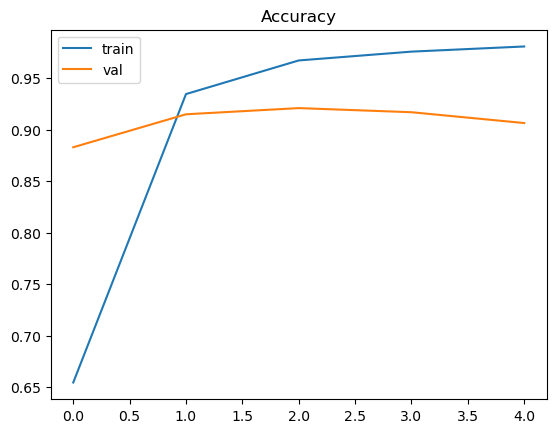

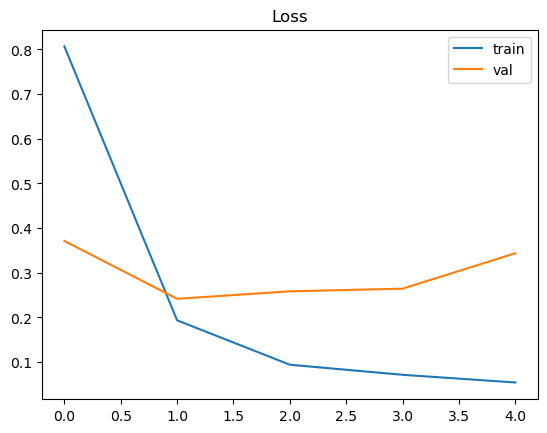

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()
plt.show()


## Model Evaluation: Classification Report and Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

       happy       0.88      0.86      0.87       275
         sad       0.87      0.97      0.92       695
       angry       0.92      0.81      0.86       449
     neutral       0.95      0.93      0.94       581

    accuracy                           0.91      2000
   macro avg       0.91      0.89      0.90      2000
weighted avg       0.91      0.91      0.90      2000



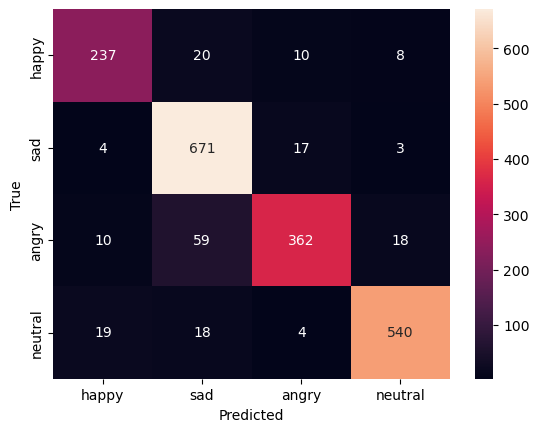

In [41]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_test is one-hot → convert to class indices
y_test_int = np.argmax(y_test, axis=1)

# y_pred already integer class indices
y_pred = np.argmax(model.predict(X_test), axis=1)

# Define class mapping
inv_class_map = {0: "happy", 1: "sad", 2: "angry", 3: "neutral"}

# Classification report
print(classification_report(y_test_int, y_pred, target_names=list(inv_class_map.values())))

# Confusion matrix
cm = confusion_matrix(y_test_int, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=list(inv_class_map.values()),
            yticklabels=list(inv_class_map.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Mapping Emotions to Emojis

In [42]:
emoji_dict = {
    "happy": "😄",
    "sad": "😢",
    "angry": "😡",
    "surprised": "😲",
    "fear": "😱",
    "neutral": "😐"
}

## Interactive Chatbot for Emotion Detection

In [64]:
def predict_emotion(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred_class = np.argmax(model.predict(padded), axis=1)[0]
    emotion = le.inverse_transform([pred_class])[0]
    emoji = emoji_dict.get(emotion, "")
    return emotion, emoji

print("\n=== Interactive Chatbot ===")
print("Type 'quit' to exit.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    emotion, emoji = predict_emotion(user_input)
    print(f"You said: {user_input}")
    print(f"Bot ({emotion} {emoji}): I detected your emotion!")
    print("-" * 50)  # optional separator


=== Interactive Chatbot ===
Type 'quit' to exit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
You said: i offend easily when i feel my intelligence is insulted
Bot (angry 😡): I detected your emotion!
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
You said: i feel ugly i cover myself with a beautiful blanket in a make believe gown
Bot (sad 😢): I detected your emotion!
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
You said: i am excited to go for vacation
Bot (happy 😄): I detected your emotion!
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
You said: i hope you feel incredibly cool now
Bot (happy 😄): I detected your emotion!
--------------------------------------------------


## Visualizing Model Accuracy During Training

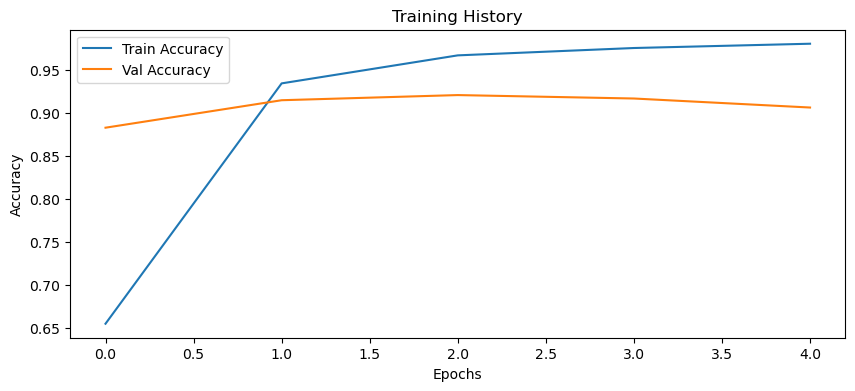

In [44]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.show()

## Persisting LSTM Model, Tokenizer, and Class Mapping

In [45]:
# Save the trained LSTM model
model.save("models/best_model.h5")

# Save the tokenizer
import pickle
with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the inverse class map
inv_class_map = {0: "happy", 1: "sad", 2: "angry", 3: "neutral"}
with open("models/inv_class_map.pkl", "wb") as f:
    pickle.dump(inv_class_map, f)


## Loading Trained Model and Artifacts

In [46]:
import tensorflow as tf
import pickle

MODEL_PATH = "models/best_model.h5"
TOKENIZER_PATH = "models/tokenizer.pkl"
INV_CLASS_MAP_PATH = "models/inv_class_map.pkl"

# Load model
tf_model = tf.keras.models.load_model(MODEL_PATH)

# Load tokenizer
with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

# Load inverse class map
with open(INV_CLASS_MAP_PATH, "rb") as f:
    inv_class_map = pickle.load(f)


## Deploying the Emotion-Aware Chatbot with Gradio

## Emotion Detection Chatbot with Memory and Probability Visualization

In [71]:
# --- Imports ---
import gradio as gr
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

#--- Pretrained tokenizer & model ---
#Make sure you load your tokenizer and model objects from previous cells
#Example:
import pickle
tokenizer = pickle.load(open("models/tokenizer.pkl", "rb"))
tf_model = tf.keras.models.load_model("models/best_model.h5")
inv_class_map = pickle.load(open("models/inv_class_map.pkl", "rb"))

# For demo, define inv_class_map and dummy RESPONSES
inv_class_map = {0: "happy", 1: "sad", 2: "angry", 3: "neutral"}
RESPONSES = {
    "happy": ["😄 That's great! Tell me more."],
    "sad": ["😢 I'm here for you."],
    "angry": ["😡 I understand your anger."],
    "neutral": ["😐 Got it."]
}

MAX_LEN = 64
memory = []

# --- Utility functions ---
def basic_clean(text):
    return text.lower().strip()

def make_sequences(tokenizer, texts, max_len):
    seqs = tokenizer.texts_to_sequences(texts)
    return tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len)

def store_in_memory(user_message):
    clean_msg = basic_clean(user_message)
    memory.append({"text": user_message, "clean": clean_msg})

def refer_to_memory(user_message, response):
    if len(memory) < 2:
        return response
    msg_lower = basic_clean(user_message)
    question_words = ["what", "who", "where", "which", "when", "how", "do you remember", "recall", "previous"]
    if any(qw in msg_lower for qw in question_words):
        prev_messages = [entry["clean"] for entry in memory[:-1]]
        tfidf = TfidfVectorizer().fit_transform(prev_messages + [msg_lower])
        sim_matrix = cosine_similarity(tfidf[-1], tfidf[:-1])
        best_idx = sim_matrix.argmax()
        if sim_matrix[0, best_idx] > 0.1:
            return f"🤖 I remember you said: '{memory[best_idx]['text']}'"
    return response

def plot_probabilities(df):
    fig, ax = plt.subplots()
    ax.bar(df["Emotion"], df["Probability"])
    ax.set_ylim(0,1)
    ax.set_ylabel("Probability")
    ax.set_title("Emotion Probabilities")
    return fig

def classify_and_respond(user_message, history=None):
    history = history or []
    store_in_memory(user_message)

    # Prepare text for model
    clean = basic_clean(user_message)
    seq = make_sequences(tokenizer, [clean], max_len=MAX_LEN)
    probs = tf_model.predict(seq)[0]
    pred_idx = int(np.argmax(probs))
    emotion = inv_class_map[pred_idx]

    # Low-confidence fallback
    if probs[pred_idx] < 0.3 or np.count_nonzero(seq) == 0:
        emotion = "neutral"  # simple fallback, can add keyword matching

    response = np.random.choice(RESPONSES[emotion])
    response = refer_to_memory(user_message, response)

    prob_df = pd.DataFrame({
        "Emotion": [inv_class_map[i].capitalize() for i in range(len(probs))],
        "Probability": [float(probs[i]) for i in range(len(probs))]
    })

    history.append([user_message, response])
    return "", history, plot_probabilities(prob_df)

# --- Gradio UI ---
with gr.Blocks() as demo:
    gr.Markdown("# Emotion Detection Chatbot")
    gr.Markdown("The bot remembers your previous messages and answers questions based on them.")

    chatbot = gr.Chatbot()
    user_input = gr.Textbox(placeholder="Type your message here...", lines=2)
    prob_plot = gr.Plot()

    user_input.submit(classify_and_respond, inputs=[user_input, chatbot], outputs=[user_input, chatbot, prob_plot])
    demo.launch()


C:\Users\rathi\AppData\Local\Temp\ipykernel_14760\500033502.py:95: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7879
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [77]:
# ===============================
#        IMPORTS
# ===============================
import gradio as gr
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ===============================
#        LOAD MODEL FILES
# ===============================
MODEL_PATH = "models/best_model.h5"
TOKENIZER_PATH = "models/tokenizer.pkl"
INV_CLASS_MAP_PATH = "models/inv_class_map.pkl"

tokenizer = pickle.load(open(TOKENIZER_PATH, "rb"))
tf_model = tf.keras.models.load_model(MODEL_PATH)
inv_class_map = pickle.load(open(INV_CLASS_MAP_PATH, "rb"))

print("Loaded class map:", inv_class_map)

# ===============================
#        GLOBAL STATE
# ===============================
MAX_LEN = 64
memory = []
last_movie = None   # explicit movie memory

RESPONSES = {
    "happy": ["😄 That's great to hear!"],
    "sad": ["😢 I'm here for you."],
    "angry": ["😡 I understand your frustration."],
    "neutral": ["😐 Got it. Please continue."]
}

# ===============================
#   KEYWORDS & INTENTS
# ===============================
KEYWORDS = {
    "happy": ["happy", "excited", "joy", "joyful", "thankful", "grateful", "peaceful"],
    "sad": ["sad", "down", "lonely", "depressed", "fake", "hurt", "empty", "lost"],
    "angry": ["angry", "mad", "furious", "annoyed", "irritated", "hate"]
}

NEUTRAL_PHRASES = [
    "yesterday", "today", "i watched", "movie", "weather",
    "train", "bus", "raining", "walking", "travelling"
]

MEMORY_QUESTIONS = [
    "what movie", "what did i", "do you remember",
    "recall", "previous", "earlier"
]

# ===============================
#        UTILITIES
# ===============================
def basic_clean(text):
    return text.lower().strip()

def make_sequences(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=MAX_LEN)

def keyword_override(text):
    words = re.findall(r"\b\w+\b", text)
    for emotion, keys in KEYWORDS.items():
        for k in keys:
            if k in words:   # whole-word match only
                return emotion
    return None

def is_neutral_statement(text):
    return any(p in text for p in NEUTRAL_PHRASES)

def is_memory_question(text):
    return any(q in text for q in MEMORY_QUESTIONS)

def extract_movie(text):
    match = re.search(r"movie\s+['\"]?(.+?)['\"]?$", text)
    if match:
        return match.group(1).strip()
    return None

def store_in_memory(msg):
    global last_movie
    clean = basic_clean(msg)
    memory.append({"text": msg, "clean": clean})

    movie = extract_movie(clean)
    if movie:
        last_movie = movie

def recall_from_memory(user_msg):
    global last_movie
    msg = basic_clean(user_msg)

    if "movie" in msg:
        if last_movie:
            return f"🎬 You watched the movie **{last_movie.title()}**."
        else:
            return "🎬 You mentioned watching a movie, but you didn’t say its name."

    if len(memory) < 2:
        return "🤖 I don't have anything stored yet."

    prev = [m["clean"] for m in memory[:-1]]
    tfidf = TfidfVectorizer().fit_transform(prev + [msg])
    sims = cosine_similarity(tfidf[-1], tfidf[:-1])
    idx = sims.argmax()

    if sims[0, idx] > 0.15:
        return f"🤖 You previously said: \"{memory[idx]['text']}\""

    return "🤖 I couldn't recall that clearly."

def plot_probabilities(df):
    fig, ax = plt.subplots()
    ax.bar(df["Emotion"], df["Probability"])
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.set_title("Emotion Probabilities")
    return fig

# ===============================
#        CORE FUNCTION
# ===============================
def classify_and_respond(user_message, history):
    clean = basic_clean(user_message)

    # ---- 1. MEMORY QUESTIONS (TOP PRIORITY) ----
    if is_memory_question(clean):
        response = recall_from_memory(user_message)
        history.append((user_message, response))
        return "", history, None

    # ---- STORE MESSAGE ----
    store_in_memory(user_message)

    seq = make_sequences([clean])
    token_count = np.count_nonzero(seq)

    # ---- 2. NEUTRAL FACTS ----
    if is_neutral_statement(clean) or token_count < 3:
        emotion = "neutral"
        probs = np.zeros(len(inv_class_map))

    # ---- 3. EMOTION DETECTION ----
    else:
        probs = tf_model.predict(seq, verbose=0)[0]
        ml_emotion = inv_class_map[int(np.argmax(probs))]
        rule_emotion = keyword_override(clean)
        emotion = rule_emotion if rule_emotion else ml_emotion

    response = np.random.choice(RESPONSES[emotion])
    history.append((user_message, response))

    prob_df = pd.DataFrame({
        "Emotion": [inv_class_map[i].capitalize() for i in range(len(inv_class_map))],
        "Probability": [float(probs[i]) for i in range(len(inv_class_map))]
    })

    return "", history, plot_probabilities(prob_df)

# ===============================
#        GRADIO UI
# ===============================
with gr.Blocks() as demo:
    gr.Markdown("# 🧠 Emotion Detection Chatbot (FINAL VERSION)")
    gr.Markdown("Priority-based logic: Memory → Neutral → Emotion")

    chatbot = gr.Chatbot(height=330)
    user_input = gr.Textbox(placeholder="Type your message...", lines=2)
    prob_plot = gr.Plot()

    user_input.submit(
        classify_and_respond,
        inputs=[user_input, chatbot],
        outputs=[user_input, chatbot, prob_plot]
    )

demo.launch()


C:\Users\rathi\AppData\Local\Temp\ipykernel_14760\2713077535.py:177: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=330)


Loaded class map: {0: 'angry', 1: 'happy', 2: 'neutral', 3: 'sad'}
* Running on local URL:  http://127.0.0.1:7885
* To create a public link, set `share=True` in `launch()`.


# Final Emotion Detection and Adding Confidence level with Emoji Chatbot Application

In [68]:

# FINAL EMOTION CHATBOT APP
# =========================

# --- Imports ---
import gradio as gr
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --------------------------------------------------
# Load pretrained tokenizer & model (from earlier cells)
# --------------------------------------------------
tokenizer = pickle.load(open("models/tokenizer.pkl", "rb"))
tf_model = tf.keras.models.load_model("models/best_model.h5")

inv_class_map = {0: "happy", 1: "sad", 2: "angry", 3: "neutral"}

# --------------------------------------------------
# Response Templates
# --------------------------------------------------
RESPONSES = {
    "happy": [
        "😄 That's wonderful to hear! Can you tell me more?",
        "😊 I'm glad you're feeling good — want to share why?",
        "🎉 That sounds great! What's making you feel this way?"
    ],
    "sad": [
        "😢 I'm sorry you're feeling this way. I'm here to listen.",
        "💙 That sounds really tough — do you want to talk about it?",
        "🤍 I hear you. Would you like support or just someone to listen?"
    ],
    "angry": [
        "😡 I can sense your frustration. Want to tell me what happened?",
        "🔥 That sounds upsetting. Do you want to vent or find solutions?",
        "⚠️ I hear your anger — it's valid. How can I help?"
    ],
    "neutral": [
        "😐 Got it. How can I help further?",
        "📌 Noted. Would you like to continue?",
        "📝 Okay. Let me know what you'd like to do next."
    ]
}

MAX_LEN = 64
memory = []

# --------------------------------------------------
# Emotion Keyword Lexicons (NON-OVERLAPPING)
# --------------------------------------------------
happy_words = [
    "happy", "joy", "joyful", "cheerful", "excited", "thrilled", "delighted",
    "love", "loving", "amazing", "awesome", "great", "fantastic",
    "wonderful", "excellent", "fun", "enjoy", "smile", "laugh",
    "proud", "grateful", "thankful", "hopeful", "confident",
    "peaceful", "content", "yay", "woohoo"
]

sad_words = [
    "sad", "unhappy", "down", "depressed", "lonely", "alone","crying","worry","worried","worrying",
    "cry", "crying", "tears", "hurt", "painful", "miserable",
    "hopeless", "helpless", "tired", "exhausted", "empty",
    "heartbroken", "anxious", "worried"
]

angry_words = [
    "angry", "mad", "furious", "rage", "hate", "stressful","stressed","stress",
    "annoyed", "irritated", "frustrated",
    "outraged", "resentful", "bitter",
    "hostile", "argument", "conflict",
    "complaint", "terrible", "awful"
]

neutral_words = [
    "information", "data", "process", "system", "procedure",
    "method", "task", "status", "update", "report",
    "analysis", "details", "record", "result"
]

# --------------------------------------------------
# Utility Functions
# --------------------------------------------------
def basic_clean(text):
    return text.lower().strip()

def make_sequences(tokenizer, texts, max_len):
    seqs = tokenizer.texts_to_sequences(texts)
    return tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len)

def store_in_memory(msg):
    memory.append({"text": msg, "clean": basic_clean(msg)})

def refer_to_memory(user_message, response):
    if len(memory) < 2:
        return response

    msg = basic_clean(user_message)
    recall_triggers = ["what","why","How","when","where","remember", "recall", "previous", "earlier", "before"]

    if any(t in msg for t in recall_triggers):
        prev = [m["clean"] for m in memory[:-1]]
        tfidf = TfidfVectorizer().fit_transform(prev + [msg])
        sim = cosine_similarity(tfidf[-1], tfidf[:-1])
        idx = sim.argmax()
        if sim[0, idx] > 0.2:
            return f"🤖 I remember you said: '{memory[idx]['text']}'"

    return response

def plot_probabilities(df):
    fig, ax = plt.subplots()
    ax.bar(df["Emotion"], df["Probability"])
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.set_title("Emotion Probabilities")
    return fig

# --------------------------------------------------
# Core Classification Logic 
# --------------------------------------------------
def classify_and_respond(user_message, history=None):
    history = history or []
    store_in_memory(user_message)

    clean = basic_clean(user_message)
    seq = make_sequences(tokenizer, [clean], MAX_LEN)
    probs = tf_model.predict(seq, verbose=0)[0]

    pred_idx = int(np.argmax(probs))
    confidence = float(probs[pred_idx])
    emotion = inv_class_map[pred_idx]

    # -----------------------------
    # Keyword override ONLY when confidence is low
    # -----------------------------
    if confidence < 0.45:
        if any(w in clean for w in sad_words):
            emotion = "sad"
        elif any(w in clean for w in angry_words):
            emotion = "angry"
        elif any(w in clean for w in happy_words):
            emotion = "happy"
        else:
            emotion = "neutral"

    response = np.random.choice(RESPONSES[emotion])

    conf_level = (
        "High" if confidence >= 0.6 else
        "Medium" if confidence >= 0.4 else
        "Low"
    )

    response += f"\n\n🧠 Detected Emotion: {emotion.capitalize()}\n📊 Confidence: {confidence:.2f} ({conf_level})"

    response = refer_to_memory(user_message, response)

    prob_df = pd.DataFrame({
        "Emotion": [inv_class_map[i].capitalize() for i in range(len(probs))],
        "Probability": [float(p) for p in probs]
    })

    history.append([user_message, response])
    return "", history, plot_probabilities(prob_df)


# Gradio UI
# -----------
with gr.Blocks() as demo:
    gr.Markdown("# 🧠 Emotion Detection Chatbot")
    gr.Markdown(
        "** Emotion Recognition using LSTM + Confidence-Aware Heuristics**"
    )

    chatbot = gr.Chatbot(height=350)
    user_input = gr.Textbox(placeholder="Type your message here...", lines=2)
    prob_plot = gr.Plot()

    user_input.submit(
        classify_and_respond,
        inputs=[user_input, chatbot],
        outputs=[user_input, chatbot, prob_plot]
    )

    demo.launch()


C:\Users\rathi\AppData\Local\Temp\ipykernel_14760\2462087500.py:177: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=350)


* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


#  Final Emotion Detection Chatbot with LSTM and Confidence-Aware Heuristics

In [ ]:
# --- Imports ---
import gradio as gr
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --------------------------------------------------
# Load pretrained tokenizer & model (FIXED)
# --------------------------------------------------
TOKENIZER_PATH = "models/tokenizer.pkl"
MODEL_PATH = "models/best_model.h5"

assert os.path.exists(TOKENIZER_PATH), " tokenizer.pkl not found"
assert os.path.exists(MODEL_PATH), " best_model.h5 not found"

with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

tf_model = tf.keras.models.load_model(MODEL_PATH)

print("✅ Tokenizer and model loaded successfully")

inv_class_map = {0: "happy", 1: "sad", 2: "angry", 3: "neutral"}
# --------------------------------------------------
# Response Templates
# --------------------------------------------------
RESPONSES = {
    "happy": [
        "😄 That's wonderful to hear! Can you tell me more?",
        "😊 I'm glad you're feeling good — want to share why?",
        "🎉 That sounds great! What's making you feel this way?"
    ],
    "sad": [
        "😢 I'm sorry you're feeling this way. I'm here to listen.",
        "💙 That sounds really tough — do you want to talk about it?",
        "🤍 I hear you. Would you like support or just someone to listen?"
    ],
    "angry": [
        "😡 I can sense your frustration. Want to tell me what happened?",
        "🔥 That sounds upsetting. Do you want to vent or find solutions?",
        "⚠️ I hear your anger — it's valid. How can I help?"
    ],
    "neutral": [
        "😐 Got it. How can I help further?",
        "📌 Noted. Would you like to continue?",
        "📝 Okay. Let me know what you'd like to do next."
    ]
}

MAX_LEN = 64
memory = []

# --------------------------------------------------
# Emotion Keyword Lexicons (NON-OVERLAPPING)
# --------------------------------------------------
happy_words = [
    "happy", "joy", "joyful", "cheerful", "excited", "thrilled", "delighted",
    "love", "loving", "amazing", "awesome", "great", "fantastic",
    "wonderful", "excellent", "fun", "enjoy", "smile", "laugh",
    "proud", "grateful", "thankful", "hopeful", "confident",
    "peaceful", "content", "yay", "woohoo"
]

sad_words = [
    "sad", "unhappy", "down", "depressed", "lonely", "alone",
    "cry", "crying", "tears", "hurt", "painful", "miserable",
    "hopeless", "helpless", "tired", "exhausted", "empty",
    "heartbroken", "anxious", "worried"
]

angry_words = [
    "angry", "mad", "furious", "rage", "hate",
    "annoyed", "irritated", "frustrated",
    "outraged", "resentful", "bitter",
    "hostile", "argument", "conflict",
    "complaint", "terrible", "awful"
]

neutral_words = [
    "information", "data", "process", "system", "procedure",
    "method", "task", "status", "update", "report",
    "analysis", "details", "record", "result"
]
# --------------------------------------------------
# Utility Functions
# --------------------------------------------------
def basic_clean(text):
    return text.lower().strip()

def make_sequences(tokenizer, texts, max_len):
    seqs = tokenizer.texts_to_sequences(texts)
    return tf.keras.preprocessing.sequence.pad_sequences(
        seqs, maxlen=max_len
    )

def store_in_memory(msg):
    memory.append({"text": msg, "clean": basic_clean(msg)})

def refer_to_memory(user_message, response):
    if len(memory) < 2:
        return response

    msg = basic_clean(user_message)
    recall_triggers = ["what", "why", "how", "when", "where", "remember"]

    if any(t in msg for t in recall_triggers):
        prev = [m["clean"] for m in memory[:-1]]
        tfidf = TfidfVectorizer().fit_transform(prev + [msg])
        sim = cosine_similarity(tfidf[-1], tfidf[:-1])
        idx = sim.argmax()
        if sim[0, idx] > 0.2:
            return f"🤖 I remember you said: '{memory[idx]['text']}'"

    return response

def plot_probabilities(df):
    fig, ax = plt.subplots()
    ax.bar(df["Emotion"], df["Probability"])
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.set_title("Emotion Probabilities")
    return fig

# Core Classification Logic 
# --------------------------
def classify_and_respond(user_message, history=None):
    history = history or []
    store_in_memory(user_message)

    clean = basic_clean(user_message)
    seq = make_sequences(tokenizer, [clean], MAX_LEN)

    probs = tf_model.predict(seq, verbose=0)[0]

    pred_idx = int(np.argmax(probs))
    confidence = float(probs[pred_idx])
    emotion = inv_class_map[pred_idx]

    # Keyword override ONLY if model confidence is low
    if confidence < 0.45:
        if any(w in clean for w in sad_words):
            emotion = "sad"
        elif any(w in clean for w in angry_words):
            emotion = "angry"
        elif any(w in clean for w in happy_words):
            emotion = "happy"
        else:
            emotion = "neutral"

    response = np.random.choice(RESPONSES[emotion])

    conf_level = (
        "High" if confidence >= 0.6 else
        "Medium" if confidence >= 0.4 else
        "Low"
    )

    response += (
        f"\n\n🧠  Emotion Detection: {emotion.capitalize()}"
        f"\n📊 Confidence: {confidence:.2f} ({conf_level})"
    )

    response = refer_to_memory(user_message, response)

    prob_df = pd.DataFrame({
        "Emotion": [inv_class_map[i].capitalize() for i in range(len(probs))],
        "Probability": [float(p) for p in probs]
    })

    history.append([user_message, response])
    return "", history, plot_probabilities(prob_df)

# --------------------------------------------------
# Gradio UI
# --------------------------------------------------
with gr.Blocks() as demo:
    gr.Markdown("# 🧠 Emotion Detection Chatbot")
    gr.Markdown("**Emotion Recognition using LSTM + Confidence-Aware Heuristics**")

    chatbot = gr.Chatbot(height=350)
    user_input = gr.Textbox(placeholder="Type your message here...", lines=2)
    prob_plot = gr.Plot()

    user_input.submit(
        classify_and_respond,
        inputs=[user_input, chatbot],
        outputs=[user_input, chatbot, prob_plot]
    )

demo.launch()

C:\Users\rathi\AppData\Local\Temp\ipykernel_14760\1628307670.py:191: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=350)


✅ Tokenizer and model loaded successfully
* Running on local URL:  http://127.0.0.1:7878
* To create a public link, set `share=True` in `launch()`.
